In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import InceptionV3

from imgaug import augmenters 

In [3]:
train_path = './cnn/pneumonia_revamped/chest_xray/train'
test_path = './cnn/pneumonia_revamped/chest_xray/test/'
valid_path = './cnn/pneumonia_revamped/chest_xray/val/'

In [4]:
batch_size = 32

img_height = 75
img_width = 75

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


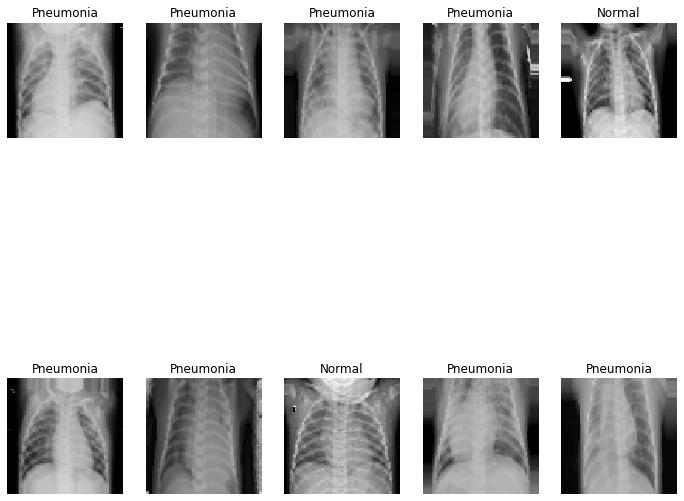

In [7]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [8]:
expert_conv = InceptionV3(weights = 'imagenet', include_top = False,input_shape=(img_width,img_height,3))

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
# expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [9]:
expert_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 22,073,377
Trainable params: 22,038,945
Non-trainable params: 34,432
_______________________________________

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(expert_model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.3,min_lr=0.000001)
callbacks_list = [early,learning_rate_reduction]

In [12]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


C:\Users\vishw\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [13]:
expert_model.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
163/163 [==============================] - 63s 386ms/step - loss: 0.6403 - accuracy: 0.5215 - val_loss: 0.6368 - val_accuracy: 0.6875
Epoch 2/25
163/163 [==============================] - 61s 374ms/step - loss: 0.4751 - accuracy: 0.7362 - val_loss: 0.5580 - val_accuracy: 0.7500
Epoch 3/25
163/163 [==============================] - 64s 391ms/step - loss: 0.3226 - accuracy: 0.8867 - val_loss: 0.4603 - val_accuracy: 0.6875
Epoch 4/25
163/163 [==============================] - 61s 374ms/step - loss: 0.2562 - accuracy: 0.9109 - val_loss: 0.4398 - val_accuracy: 0.8125
Epoch 5/25
163/163 [==============================] - 61s 374ms/step - loss: 0.2135 - accuracy: 0.9260 - val_loss: 0.4932 - val_accuracy: 0.8125
Epoch 6/25
163/163 [==============================] - 61s 373ms/step - loss: 0.1972 - accuracy: 0.9308 - val_loss: 0.5248 - val_accuracy: 0.8125
Epoch 7/25
163/163 [==============================] - 61s 373ms/step - loss: 0.1827 - accuracy: 0.9331 - val_loss: 0.5097 - val_ac

KeyboardInterrupt: 

<AxesSubplot:>

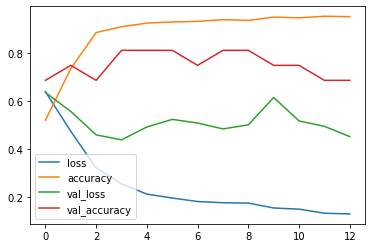

In [14]:
pd.DataFrame(expert_model.history.history).plot()

In [15]:
test_accu = expert_model.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

20/20 [==============================] - 5s 266ms/step - loss: 0.4796 - accuracy: 0.8846
The testing accuracy is -  88.46153616905212 %


## Evaluate

In [16]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [17]:
y_bar = np.round(expert_model.predict(test)).reshape(-1)
y_act = test.labels

In [18]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.8846153846153846
ROC-AUC score:  0.8815926243955349
F1 score:  0.9095477386934674
Log Loss:  3.98527930955387
